# [SC57 - Working with big, multi-dimensional geoscientific datasets in Python: a tutorial introduction to xarray](http://meetingorganizer.copernicus.org/EGU2017/session/25651)  
  
  
* Original notebook by [Stephan Hoyer](http://stephanhoyer.com), Rossbypalooza, 2016.  
* Modified by Edward Byers, Matthew Gidden and [Fabien Maussion](http://fabienmaussion.info/) for EGU General Assembly 2017, Vienna, Austria
* Modified by C. Gentemann for GHRSST Science Team Tutorial 2019, Rome, Italy
* Modified by C. Gentemann for OceanHackWeek 2019, Seattle, WA
* PODAACPY file search added by Lewis John McGibbney
  

# With

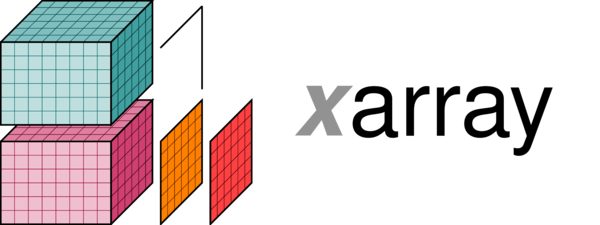

1. you can read netcdf files easily
1. easily intercompare different gridded datasets, even when they are on different grids
1. make timeseries and visualize them

# Structure of this tutorial

1. Searching for data at NASA's PODAAC
1. Opening data
1. Data plotting, exploration, subsetting
1. Comparing two datasets
1. Comparing timeseries of data


# 1. Key features of `xarray`

*  `xarray` is an open source project and Python package
*  `xarray` has been designed to perform **labelled** data analysis on **multi-dimensional** arrays
* the `xarray` approach adopts the Common Data Model for **self-describing scientific data** in widespread use in the Earth sciences
*  `xarray.Dataset` is an in-memory representation of a netCDF file.
* `xarray` is built on top of the dataprocessing library [Pandas](http://pandas.pydata.org) (the best way to work with tabular data (e.g., CSV files) in Python)

# Our data

- numeric
- multi-dimensional
- labelled
- (lots of) metadata
- sometimes (very) large

## What is `xarray` good for?
* Gridded, multi-dimensional and large datasets, commonly used in earth sciences, but also increasingly finance, engineering (signal/image processing), and biological sciences
* Integration with other data analysis packages such as Pandas 
* I/O operations (NetCDF)
* Plotting
* Out of core computation and parallel processing
* ...

# 2. Basic operations in `xarray`

-------------------

## Import python packages

You are going to want numpy, pandas, matplotlib.pyplot, podaaacpy, and xarray

In [29]:
import warnings
warnings.simplefilter('ignore') # filter some warning messages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#for search capabilites import podaacpy
import podaac.podaac as podaac

# then create an instance of the Podaac class
p = podaac.Podaac()
#to obtain rich information from PO.DAAC Drive, import and creat an instance of Drive
from podaac import drive as drive
#note autherntication credentials are provided in the 'podaac.ini' file
#C:\\Users\\gentemann\\Miniconda3\\envs\\satenv\\lib\\site-packages\\podaac\\tests\\podaac.ini
d = drive.Drive('.\podaac.ini', None, None)


In [6]:
dresult = p.dataset_search(keyword='mur',start_time='2018-09-01T00:00:00Z',end_time='2018-09-15T23:59:59Z')
gresult = p.granule_search(dataset_id='PODAAC-GHGMR-4FJ04',start_time='2018-09-01T00:00:00Z',end_time='2018-09-15T23:59:59Z')
#use podaac drive to find we provide a convenience function which enables easy access to all Drive urls
urls = d.mine_drive_urls_from_granule_search(granule_search_response=gresult)
urls_mur = [w.replace('-tools.jpl.nasa.gov/drive/files/', '-opendap.jpl.nasa.gov/opendap/') for w in urls]
print(urls_mur)

['https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/244/20180901090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/245/20180902090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/246/20180903090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/247/20180904090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/248/20180905090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/249/20180906090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'https://podaac-opend

We'll start with the MUR SST dataset. Other tutorial examples [here](https://github.com/pydata/xarray/tree/master/examples).

## 2. Examining your data

* With well designed mdatasets that follow Climate Forecast (CF) conventions, you will usually get coordinates of lat,lon,time which makes it easy to select data and visualize it in different ways.  

* Notice that the time is automatically converted into a np.datetime64 format which can be queried for month, day, etc.  All the variables that are CF compliant are automatically converted (if needed) and read in so that you can immediately start working with the data.  

* Above, you can see that the dimensions are lat, lon, and time

* The coordinates of the datasets are also lat,lon, and time


use [xr.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) to open the provided url and print the dataset

* url is a text string to an online dataset.  When you open a file, you can just use the file name and path or you can just use the url for files that are available online.  If you are running this on the cloud you could even call cloud located data

* Here, we are reading in a global SST dataset called CMC from NASA's PO.DAAC
   

## Let's open a SST dataset
Below, let's open MUR SSTs using xarray and a PODAAC OpenDAP URL.
To open a file use [xr.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)

The url filename we want to use is already included for you.  You can give a local filename or an opendap URL.

Then just print out the file details by just typing the dataset name, ds_sst_mur

## Metadata --- Examining your data


* The data variable (analysed_sst) has the labeled dimensions and metadata attached.  You can see additional metadata (if it exists) by looking at the data variable of interest.  

* Below, type 
```ds_sst_mur.ana``` then hit tab to autocomplete.  
* Then run the cell by holding shift and pressing enter.



In [30]:
ds_sst_mur = xr.open_dataset(urls_mur[0])
print(ds_sst_mur)
ds_sst_mur.analysed_sst.plot()

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2018-09-01T09:00:00
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -179.99 -179.98 -179.97 ... 179.99 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] ...
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
  

IndexError: The indexing operation you are attempting to perform is not valid on netCDF4.Variable object. Try loading your data into memory first by calling .load().

## Plot the SST.  
### Notice xarray adds labels and title to the plot and colorbar.  

Sometimes the metadata is great and you get exactly the label you need, but sometimes you want to change the label.  Xarray plotting [help](http://xarray.pydata.org/en/stable/plotting.html). A really nice feature of xarray is that it uses the metadata to label the axis.  Let's change the colorbar label by changing the `long_name` attribute

In [ ]:
#print out the attributes for `analysed_sst`
ds_sst_mur.analysed_sst.attrs

In [24]:
#print out the attributes for `analysed_sst`
ds_sst_mur.analysed_sst.attrs['units']='K'
ds_sst_mur.analysed_sst.attrs['long_name']='SST'

IndexError: The indexing operation you are attempting to perform is not valid on netCDF4.Variable object. Try loading your data into memory first by calling .load().

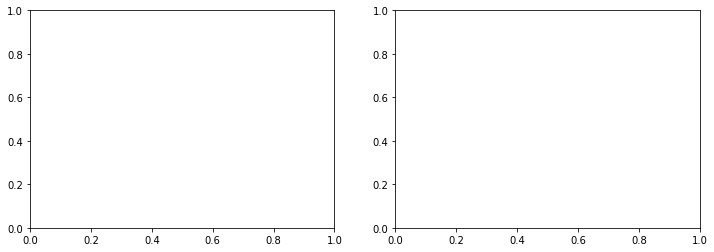

In [26]:
fig, axes = plt.subplots(ncols=2,figsize=[12,4])
ds_sst_mur.analysed_sst.plot(ax=axes[0])
ds_sst_mur.mask.plot(ax=axes[1])

## Mask out land values using .where

In [ ]:
ds_sst_masked = ds_sst_mur.where(ds_sst_mur.mask==1)
ds_sst_masked.analysed_sst.plot()

## Subset the data using .sel to the Atlantic region

In [ ]:
subset_mur = ds_sst_masked.sel(lat=slice(15,45),lon=slice(-100,-40))
subset_mur.analysed_sst.plot()

['https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/243/20180831120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/244/20180901120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/245/20180902120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/246/20180903120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/247/20180904120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc', 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/248/20180905120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc

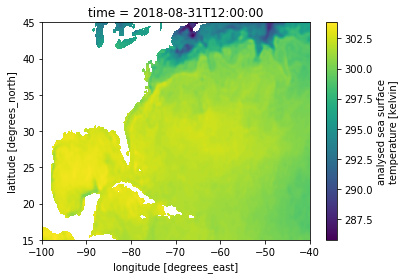

In [8]:
#dresult = p.dataset_search(keyword='ostia',start_time='2018-09-01T00:00:00Z',end_time='2018-09-15T23:59:59Z')
gresult = p.granule_search(dataset_id='PODAAC-GHOST-4FK02',start_time='2018-09-01T00:00:00Z',end_time='2018-09-15T23:59:59Z')
#use podaac drive to find we provide a convenience function which enables easy access to all Drive urls
urls = d.mine_drive_urls_from_granule_search(granule_search_response=gresult)
urls_ostia = [w.replace('-tools.jpl.nasa.gov/drive/files/', '-opendap.jpl.nasa.gov/opendap/') for w in urls]
print(urls_ostia)
url = urls_ostia[0] #'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/255/20180912120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc'
ds_sst_ostia = xr.open_dataset(url)
subset_ostia = ds_sst_ostia.sel(lat=slice(15,45),lon=slice(-100,-40))
print(subset_ostia)
subset_ostia.analysed_sst.plot()

## I'd like to use the nicer land mask in ostia on the MUR data, but they aren't on the same grid.  I'll use .interp to put them on the same grid then mask the dataset together


In [19]:
#print out the lat and lon for each dataset
print(subset_mur.lon[0:10].data)
print(subset_ostia.lon[0:10].data)
print(subset_mur.lat[0:10].data)
print(subset_ostia.lat[0:10].data)

NameError: name 'subset_mur' is not defined

## subset the data, interpolate it onto the ostia grid, then mask it.
## mask ostia 
## show data

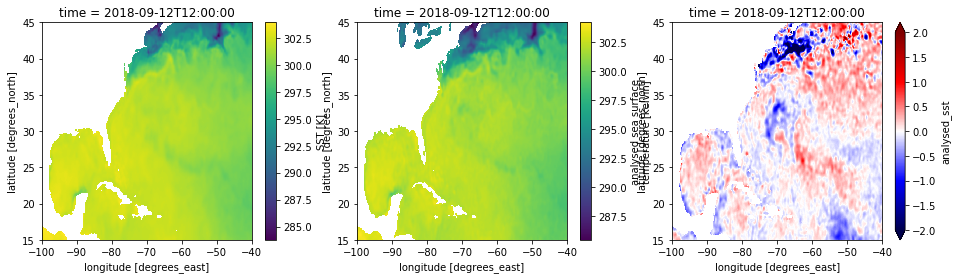

In [15]:
subset_mur_interp = subset_mur.interp(lat=subset_ostia.lat,lon=subset_ostia.lon)
subset_mur_masked = subset_mur_interp.where(subset_ostia.mask==1)
fig, axes = plt.subplots(ncols=3,figsize=[16,4])
subset_mur_masked.analysed_sst.plot(ax=axes[0])
subset_ostia.analysed_sst.plot(ax=axes[1])
(subset_ostia.analysed_sst-subset_mur_masked.analysed_sst).plot(ax=axes[2],vmin=-2,vmax=2,cmap='seismic')


# Histogram and subplots

* Create a figure with two axes using `fig, axes = plt.supplots(ncols=2)`

* To plot on a specific ax you need to set `ax = axes[0]` or `ax = axes[1]` in the hist argument

* Plot the ocean winds histogram on the first axes using [.plot.hist()](http://xarray.pydata.org/en/stable/generated/xarray.plot.hist.html) and the global land/ocean winds on the next

* Change the number of bins using an argument in hist eg.  `bins=20`

* Different [arguments](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist) for .hist  trying making a PDF by using density = True  or change the style of the plot using `histtype = 'step'`


In [ ]:
fig, axes = plt.subplots(ncols=3,figsize=[12,4])
subset_mur_masked.analysed_sst.plot.hist(bins=20,ax=axes[0],density = True,histtype='step')
subset_ostia.analysed_sst.plot.hist(bins=20,ax=axes[1],density = True,histtype='step')
subset_ostia.analysed_sst-subset_mur_masked.analysed_sst.plot.hist(bins=20,ax=axes[2],density = True,histtype='step')

In [31]:
ds_mur = xr.open_mfdataset(urls_mur,coords='minimal')
ds_ostia = xr.open_mfdataset(urls_ostia,coords='minimal')

In [32]:
ds_mur

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 7)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -179.99 -179.98 -179.97 ... 179.99 180.0
  * time              (time) datetime64[ns] 2018-09-01T09:00:00 ... 2018-09-07T09:00:00
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<shape=(7, 17999, 36000), chunksize=(1, 17999, 36000)>
    analysis_error    (time, lat, lon) float32 dask.array<shape=(7, 17999, 36000), chunksize=(1, 17999, 36000)>
    mask              (time, lat, lon) float32 dask.array<shape=(7, 17999, 36000), chunksize=(1, 17999, 36000)>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<shape=(7, 17999, 36000), chunksize=(1, 17999, 36000)>
    dt_1km_data       (time, lat, lon) timedelta64[ns] dask.array<shape=(7, 17999, 36000), chunksize=(1, 17999, 36000)>
Attributes:
    Conventions:                CF-1.5
    title:                      Dai

In [ ]:
url = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/UKMO/OSTIA/v2/2018/255/20180912120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc'
ds_sst2 = xr.open_dataset(url)
ds_sst2 = ds_sst2.drop({'analysis_error','sea_ice_fraction'}).isel(time=0).sel(lat=slice(15,45),lon=slice(-100,-40))
url = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/CMC/CMC0.1deg/v3/2018/255/20180912120000-CMC-L4_GHRSST-SSTfnd-CMC0.1deg-GLOB-v02.0-fv03.0.nc'
ds_sst = xr.open_dataset(url)
ds_sst = ds_sst.drop({'analysis_error','sea_ice_fraction'}).isel(time=0).sel(lat=slice(15,45),lon=slice(-100,-40))

In [ ]:
ds_sst2a = ds_sst_ostia.interp_like(ds_sst_mur)
ds_sst2a.analysed_sst.plot()

In [ ]:
(ds_sst2a.analysed_sst-ds_sst.analysed_sst).plot(vmin=-1,vmax=1,cmap='seismic')

## If you look at the time values you can see that the dataset is at :00, :06, :12, :18

* If you look at the lon values you can see that this dataset is 0-360 rather than -180-180, 

*  let's change the longitude coordinates using [.coords](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.coords.html) and then [.sortby](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sortby.html) |

* this bit of code can be really useful if you open lots of gridded datasets.  I keep it on a post-it note on my desktop.

## To get from 0-360 to -180-180
```
ds_ccmp.coords['lon'] = np.mod(ds_ccmp.coords['lon'] + 180,360) - 180  
ds_ccmp = ds_ccmp.sortby(ds_ccmp.lon)
```

## To get from -180-180 to 0-360
```
ds_ccmp.coords['lon'] = np.mod(ds_ccmp['lon'], 360)
ds_ccmp = ds_ccmp.sortby(ds_ccmp.lon)
```

## Okay, try going from 0-360 to -180-180 below and then print out the dataset

In [ ]:
ds_ccmp.coords['lon'] = np.mod(ds_ccmp.coords['lon'] + 180,360) - 180
ds_ccmp = ds_ccmp.sortby(ds_ccmp.lon)

## Now look at your dataset, both are -180 to 180!


In [ ]:
#Just a note, that to print out data you should us print(ds_ccmp.lon) to be 'correct'
ds_ccmp.lon

## Calculate wind speed and direction from the vectors

In [ ]:
ds_ccmp['wind_speed'] = np.sqrt(ds_ccmp.uwnd**2 + ds_ccmp.vwnd**2)
ds_ccmp['wind_dir'] = np.arctan2(ds_ccmp.vwnd,ds_ccmp.uwnd)/np.pi*180


# 5. Graphics 

``xarray`` plotting functions rely on matplotlib internally, but they make use of all available metadata to make the plotting operations more intuitive and interpretable.  Plotting examples are given [here](http://xarray.pydata.org/en/stable/plotting.html)

# Histogram and subplots

* Create a figure with two axes using `fig, axes = plt.supplots(ncols=2,figsize=[12,4])`

* To plot on a specific ax you need to set `ax = axes[0]` or `ax = axes[1]` in the hist argument

* Plot the ocean winds histogram on the first axes using [.plot.hist()](http://xarray.pydata.org/en/stable/generated/xarray.plot.hist.html) and the global land/ocean winds on the next

* Change the number of bins using an argument in hist eg.  `bins=20`

* Different [arguments](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist) for .hist  trying making a PDF by using density = True  or change the style of the plot using `histtype = 'step'`


In [ ]:
fig, axes = plt.subplots(ncols=3,figsize=[12,4])
ds_ccmp.uwnd.plot.hist(bins=20,ax=axes[0],density = True,histtype='step')
ds_ccmp.vwnd.plot.hist(bins=20,ax=axes[1],density = True,histtype='step')
ds_ccmp.wind_speed.plot.hist(bins=20,ax=axes[2],density = True,histtype='step')

### Notice the x-axis label in the right most figure.  

We probably want something more descriptive.  Xarray plotting [help](http://xarray.pydata.org/en/stable/plotting.html). A really nice feature of xarray is that it uses the metadata to label the axis.  We created the variable `wind_speed` but didn't add any metadata.  So below, let's print out the metadata attributes for uwnd then add a dictonary of attributes to `wind_speed` so that the plot will be labelled correction 

In [ ]:
ds_ccmp.uwnd.attrs

In [ ]:
ds_ccmp.wind_speed.attrs={'long_name':'wind speed at 10 meters','units':'m/s'}

In [ ]:
fig, axes = plt.subplots(ncols=3,figsize=[12,4])
ds_ccmp.uwnd.plot.hist(bins=20,ax=axes[0],density = True,histtype='step')
ds_ccmp.vwnd.plot.hist(bins=20,ax=axes[1],density = True,histtype='step')
ds_ccmp.wind_speed.plot.hist(bins=20,ax=axes[2],density = True,histtype='step')

### Selecting data and interpolation onto different grids

Data is given all all sorts of different grids.  It is often useful to put things on the same grid so that they can be compared and subsetted to the region of interest.

Let's read in a SST dataset:

In [ ]:
ds_ccmp_masked = ds_ccmp.where(ds_sst_new.mask>0)
ds_ccmp_masked.wind_speed[0,:,:].plot()

## There is no land mask in CCMP data
### to add a land mask lets use use .where and ds_ccmp.nobs to set data over land to NaN.  
### nobs is the number of observations not a land mask, but it is a quick way to see how to use .where
### The xarray function .where(cond,other) the argument other is a value that is set when cond=False


In [ ]:
ds_ccmp_ocn = ds_ccmp.where(ds_ccmp.nobs>0,np.nan)
p = ds_ccmp_ocn.wind_speed.plot(x='lon', y='lat', col='time', transform=ccrs.PlateCarree(),
                  subplot_kws={'projection': ccrs.Orthographic(-80, 35)})
for ax in p.axes.flat:
    ax.coastlines()
    ax.stock_img();


There are different options when you interpolate.  First, let's just do a linear interpolation using [.interp()](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.interp.html#xarray.Dataset.interp)

`Dataset.interp(coords=None, method='linear', assume_sorted=False, kwargs={}, **coords_kwargs))`



In [ ]:
ds_collocated = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')

In [ ]:
dif = ds_collocated_nearest.sst-ds_usv.TEMP_CTD_MEAN
print('mean difference = ',dif.mean().data)
print('STD = ',dif.std().data)

# xarray can do more!

* concatentaion
* open network located files with openDAP
* import and export Pandas DataFrames
* .nc dump to 
* groupby_bins
* resampling and reduction

For more details, read this blog post: http://continuum.io/blog/xray-dask


In [ ]:
#ds_collocated_nearest.to_netcdf('./data/new file.nc')

## Where can I find more info?

### For more information about xarray

- Read the [online documentation](http://xarray.pydata.org/)
- Ask questions on [StackOverflow](http://stackoverflow.com/questions/tagged/python-xarray)
- View the source code and file bug reports on [GitHub](http://github.com/pydata/xarray/)

### For more doing data analysis with Python:

- Thomas Wiecki, [A modern guide to getting started with Data Science and Python](http://twiecki.github.io/blog/2014/11/18/python-for-data-science/)
- Wes McKinney, [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do) (book)

### Packages building on xarray for the geophysical sciences

For analyzing GCM output:

- [xgcm](https://github.com/xgcm/xgcm) by Ryan Abernathey
- [oogcm](https://github.com/lesommer/oocgcm) by Julien Le Sommer
- [MPAS xarray](https://github.com/pwolfram/mpas_xarray) by Phil Wolfram
- [marc_analysis](https://github.com/darothen/marc_analysis) by Daniel Rothenberg

Other tools:

- [windspharm](https://github.com/ajdawson/windspharm): wind spherical harmonics by Andrew Dawson
- [eofs](https://github.com/ajdawson/eofs): empirical orthogonal functions by Andrew Dawson
- [infinite-diff](https://github.com/spencerahill/infinite-diff) by Spencer Hill 
- [aospy](https://github.com/spencerahill/aospy) by Spencer Hill and Spencer Clark
- [regionmask](https://github.com/mathause/regionmask) by Mathias Hauser
- [salem](https://github.com/fmaussion/salem) by Fabien Maussion

Resources for teaching and learning xarray in geosciences:
- [Fabien's teaching repo](https://github.com/fmaussion/teaching): courses that combine teaching climatology and xarray
